In [1]:
# Import Libraries
import sys
from tqdm import tqdm, trange

import random
import numpy as np
import pandas as pd
from numba import njit
import scipy

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.epochs import EpochAnimation
import data_analysis.visualization.publication as publication
from activations import get_activations

import models as models
from models import MLP
import simulate


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")
device = torch.device("cpu")

plot_path = "/home/loek/projects/rnn/DNN/plots/mnist/"

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


GPU available


In [3]:
# Load the data
encoding = Direct()
input_size = 28 * 28
output_size = 10

input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(torch.ravel),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)
output_transforms = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float)
    .scatter_(0, torch.tensor(y), value=1)
    .to(device)
)

train_data = datasets.MNIST(
    "./DNN/data/MNIST",
    train=True,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)
val_data = datasets.MNIST(
    "./DNN/data/MNIST",
    train=False,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)

train_datasets = [torch.utils.data.Subset(train_data, np.arange(60000))]
tracked_datasets = [val_data] + train_datasets

analyzed_data = torch.utils.data.Subset(train_data, np.arange(10000))
labels = np.array([np.argmax(y.cpu()) for x, y in analyzed_data])
analyzed_data = torch.utils.data.Subset(train_data, np.argsort(labels))
labels = labels[np.argsort(labels)]

two_points = torch.utils.data.Subset(train_data, [1, 3])

100%|██████████| 9912422/9912422 [00:01<00:00, 5780493.93it/s]


Extracting ./DNN/data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./DNN/data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56897930.40it/s]


Extracting ./DNN/data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./DNN/data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5415941.09it/s]


Extracting ./DNN/data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DNN/data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4071495.78it/s]


Extracting ./DNN/data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DNN/data/MNIST/MNIST/raw



In [4]:
## Load settings
settings = "low_init"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/mnist.txt", sep=" ", header=0).loc[settings].to_numpy()
)
model_type = getattr(models, model_type)
nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [5]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=input_size,
    output_size=output_size,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [6]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][int(len(model) / 2)],
        datasets=[analyzed_data],
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=[analyzed_data]
    ),
}

In [7]:
# D0 = 0
# DY = 0
# for input, output in analyzed_data:
#     x_norm = np.linalg.norm(input.cpu())
#     y_norm = np.linalg.norm(model(input)[0].detach().cpu())
#     D0 += (y_norm / x_norm) / len(analyzed_data)
# print(f"D0 = {D0}")

# hid_act_0 = get_activations(
#     [analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding
# )
# out_act_0 = get_activations([analyzed_data], lambda x: model(x)[0], encoding)

D0 = 0.0019050996227772004


In [8]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=64
)

Training:   2%|▏         | 1/50 [00:32<26:15, 32.15s/steps, train_loss=0.04833, val_loss=0.05025]


KeyboardInterrupt: 

In [10]:
## Plot loss
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
data_hid.index = data_hid.index.set_levels(["A", "B"], level=2)
data_output.index = data_output.index.set_levels(["A", "B"], level=2)
data_hid = data_hid.copy()
data_output = data_output.copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
epochs = list(set(train_loss.index.get_level_values("Epoch")))

animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid, transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="none",
            plot_labels=True,
            # fixed_points=dict(zip(names, outputs)),
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={},
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

ValueError: On level 2, code max (9999) >= length of level (2). NOTE: this index is in an inconsistent state

In [ ]:
# h_A = [
#     np.array(data.loc[epoch, 0, "A"])
#     for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
# ]
# h_B = [
#     np.array(data.loc[epoch, 0, "B"])
#     for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
# ]
# y_A = [
#     np.array(data.loc[epoch, 0, "A"])
#     for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
# ]
# y_B = [
#     np.array(data.loc[epoch, 0, "B"])
#     for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
# ]
# y_true_A, y_true_B = two_points[0][1].numpy(), two_points[1][1].numpy()

In [11]:
digit = 0
cond_A = labels == digit
cond_B = labels == 1

# cond_A = np.zeros(len(labels), dtype=bool)
# cond_B = np.zeros(len(labels), dtype=bool)
# cond_A[0] = True
# cond_B[-1] = True

h_A = [
    np.mean(np.array(data[cond_A].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
y_A = [
    np.mean(np.array(data[cond_A].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_A = np.mean(np.array([y.numpy() for x, y in analyzed_data])[cond_A], axis=0)
N_A = np.sum(cond_A)
h_B = [
    np.mean(np.array(data[cond_B].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.mean(np.array(data[cond_B].loc[epoch, 0, :]), axis=0)
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_B = np.mean(np.array([y.numpy() for x, y in analyzed_data])[cond_B], axis=0)
N_B = np.sum(cond_B)

In [12]:
epochs = np.arange(0, len(h_A))

dy2 = np.sum((y_true_B - y_true_A) ** 2)
h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)
y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)

dx2 = np.linalg.norm(two_points[0][0] - two_points[1][0]) ** 2

h0, y0, w0, dy = h2[0], y2[0], w[0], dy2
print(f"h0: {h0}")
print(f"y0: {y0}")
print(f"w0: {w0}")
print(f"dy: {dy}")

# epochs = epochs * mod

h0: 0.0898938775062561
y0: 0.0005591936060227454
w0: 0.00768363056704402
dy: 2.0


(0.0, 1.0021346271038056)

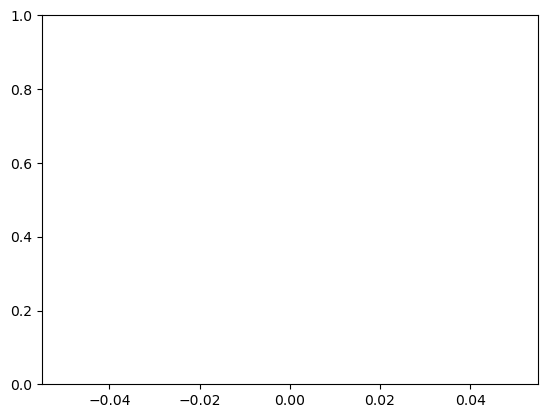

In [13]:
plt.plot([np.linalg.norm(y_A[epoch] - y_true_A) for epoch in epochs])
plt.plot([np.linalg.norm(y_B[epoch] - y_true_B) for epoch in epochs])
plt.ylim(0)

In [14]:
@njit
def der(t, z, eta_h, eta_y, dx2, dy2):
    """Right hand side of the 3d ode system."""
    h, y, w = z
    factor = 1
    return [
        -factor * eta_h * dx2 * w,
        -factor * w * (eta_y * h + eta_h * dx2 * y / h),
        -factor * (1 / 2) * eta_y * (3 * w - y + dy2) * h
        - factor * (1 / 2) * eta_h * dx2 * (y + w) * w / h,
    ]


def optimize_eta(h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 1, 100)):
    h0, y0, w0 = h2[0], y2[0], w[0]
    n_epochs = len(h2)

    ratio = h2[-1] ** 2 / (dx2 * dy2)

    def model_accuracy(pars):
        eta_h, eta_y = pars

        t_max = n_epochs

        sol = scipy.integrate.solve_ivp(
            der,
            [0, t_max],
            [h0, y0, w0],
            args=(eta_h, eta_y, dx2, dy2),
            dense_output=True,
            # rtol=1e-2,
            # atol=1e-5,
            method="Radau",
        )

        t = np.linspace(0, t_max, n_epochs)
        z = sol.sol(t)

        loss = (
            np.sum((h2 - z[0]) ** 2)
            + np.sum((y2 - z[1]) ** 2)
            + np.sum((w - z[2]) ** 2)
        )
        return loss

    # Optimize etas
    # guesses = np.logspace(-6, 1, 100)
    guess = guesses[
        np.argmin([model_accuracy(guess * np.array([ratio, 1])) for guess in guesses])
    ]

    optimal = scipy.optimize.minimize(model_accuracy, guess * np.array([ratio, 1]))
    print(f"Loss: {optimal.fun}")

    eta_h_opt, eta_y_opt = optimal.x

    return eta_h_opt, eta_y_opt

In [15]:
N = N_A + N_B

dy2 += 1e-10

Loss: 0.0


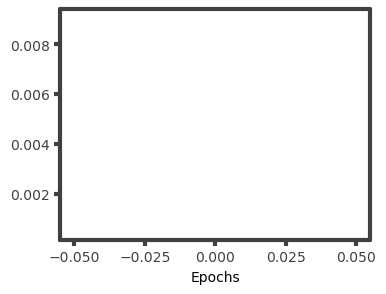

In [16]:
save = False


max_epoch = len(epochs)
# max_epoch = 25

# Fit effective learning rates
eta_h_opt, eta_y_opt = optimize_eta(
    h2[:max_epoch],
    y2[:max_epoch],
    w[:max_epoch],
    dx2,
    dy2,
    guesses=np.logspace(-6, 1, 100),
)
eta_h, eta_y = np.array((eta_h_opt, eta_y_opt))

# eta_h, eta_y = 0.5 * np.array([1, 1])


t_max = len(epochs)

sol = scipy.integrate.solve_ivp(
    der,
    [0, t_max],
    np.array([h0, y0, w0]),
    args=(eta_h, eta_y, dx2, dy2),
    dense_output=True,
    method="Radau",
)

t = np.linspace(0, t_max, len(epochs))
z = sol.sol(t)
z = z[:, :max_epoch]
t = epochs[:max_epoch]

c = 0.1
d = 1

fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(t, c * z[0], linestyle="--")
plt.plot(t, d * z[1], linestyle="--")
plt.plot(t, z[2], linestyle="--")
plt.gca().set_prop_cycle(None)
ax.plot(t, c * h2[:max_epoch], label=f"${c}||dh||^2$")
ax.plot(t, d * y2[:max_epoch], label="$||dy||^2$")
ax.plot(t, w[:max_epoch], label="$w$")
# ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=plot_path + "trajectory/" + "ode/" + "" + settings)
else:
    publication.plt_show

In [17]:
from typing import Optional

import matplotlib
from matplotlib import rc, rcParams, cycler
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.axis import Axis

# COLORS_GRADIENT = [
#     "f92485",
#     "b4189f",
#     "7409b9",
#     "540dab",
#     "480da7",
#     "3d0ba2",
#     "3f37ca",
#     "4461ed",
#     "4a93f1",
#     "4bc9f1",
# ]
COLORS_GRADIENT = [
    [
        "4bc9f1",
        "4a93f1",
        "4461ed",
        "3f37ca",
        "3d0ba2",
        "480da7",
        "540dab",
        "7409b9",
        "b4189f",
        "f92485",
    ],
    [
        "2a4858",
        "215d6e",
        "08737f",
        "00898a",
        "089f8f",
        "39b48e",
        "64c987",
        "92dc7e",
        "c4ec74",
        "fafa6e",
    ],
]
COLORS_MIXED = [
    "138086",
    "DC8665",
    "534686",
    "FEB462",
    "AF87CE",
    "6096FD",
    "EF6642",
    "A2C579",
    "860A35",
    "ADE4DB",
]
COLORS_CONTRAST = ["FF044F", "760AC0", "00D950", "9F82C9", "471664", "05DFD7"]


cdict_seq = {
    "red": (
        (0.0, 64 / 255, 64 / 255),
        (0.2, 112 / 255, 112 / 255),
        (0.4, 230 / 255, 230 / 255),
        (0.6, 253 / 255, 253 / 255),
        (0.8, 244 / 255, 244 / 255),
        (1.0, 169 / 255, 169 / 255),
    ),
    "green": (
        (0.0, 57 / 255, 57 / 255),
        (0.2, 198 / 255, 198 / 255),
        (0.4, 241 / 255, 241 / 255),
        (0.6, 219 / 255, 219 / 255),
        (0.8, 109 / 255, 109 / 255),
        (1.0, 23 / 255, 23 / 255),
    ),
    "blue": (
        (0.0, 144 / 255, 144 / 255),
        (0.2, 162 / 255, 162 / 255),
        (0.4, 146 / 255, 146 / 255),
        (0.6, 127 / 255, 127 / 255),
        (0.8, 69 / 255, 69 / 255),
        (1.0, 69 / 255, 69 / 255),
    ),
}
COLORMAP_SEQUENTIAL = matplotlib.colors.LinearSegmentedColormap(
    "COLORMAP_SEQUENTIAL", segmentdata=cdict_seq
)
try:
    matplotlib.colormaps.register(COLORMAP_SEQUENTIAL)
except ValueError:
    pass


def pub_show(colors: str = "mixed", save_path: Optional[str] = None):
    match colors.split():
        case ["mixed"]:
            color_scheme = COLORS_MIXED
        case ["gradient"]:
            color_scheme = COLORS_GRADIENT[0]
        case ["gradient", n]:
            color_scheme = COLORS_GRADIENT[int(n) - 1]
        case ["contrast"]:
            color_scheme = COLORS_CONTRAST
    rcParams["axes.prop_cycle"] = cycler(color=color_scheme)

    # rc("font", **{"sans-serif": "Go Medium"})
    # rc("font", **{"sans-serif": "Noto Sans Math"})
    rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

    SMALL_SIZE = 13
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20

    plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig = plt.gcf()
    ax = plt.gca()

    # rcParams["figure.dpi"] = 200

    # Lines
    for line in ax.get_lines():
        line.set_linewidth(2)
        line.set_solid_capstyle("round")

    # Legend
    # n_labels = len(ax.get_legend_handles_labels()[0])
    # legend = ax.get_legend()
    if ax.get_legend():
        legend = plt.legend(
            # [text.get_text() for text in legend.get_texts()],
            loc="upper right",
            fancybox=True,
            framealpha=0.9,
            shadow=True,
            borderpad=0.6,
            edgecolor="0.7",
            handlelength=1.5,
        )
        for line in legend.get_lines():
            line.set_linewidth(2.5)
        legend.get_frame().set_linewidth(2)

    # Axes
    n_ticks = 3 + int(fig.get_figheight() * 0.5)
    plt.locator_params(nbins=n_ticks - 1, min_n_ticks=n_ticks)
    ax.grid("on", alpha=0.4, linestyle="--")
    border_color = "0.25"
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines[:].set_capstyle("round")
    ax.spines[:].set_linewidth(3)
    ax.spines[:].set_color(border_color)
    for axis in ("x", "y"):
        ax.tick_params(axis=axis, colors=border_color, width=3, length=4)

    # Scatter
    for n, points in enumerate(ax.collections):
        points.set_alpha(0.5)
        mean = np.mean(points.get_offsets().data, axis=0)
        label = ax.get_legend_handles_labels()[1][n]
        plt.text(
            mean[0],
            mean[1],
            label,
            path_effects=[
                pe.Stroke(linewidth=2, foreground="w"),
                pe.Normal(),
            ],
        )
    if len(ax.get_lines()) > 0 and len(ax.collections) == 1:
        ax.collections[0].set_color("0.5")

        # Add glow
        alpha = 0.05
        color = "w"
        linewidth = 2.5
        path_effects = [
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(1.4, 0), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(-1.4, 0), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(0, -1.4), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(0, 1.4), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(1, 1), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(-1, 1), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(1, -1), alpha=alpha, foreground=color
            ),
            pe.SimpleLineShadow(
                linewidth=linewidth, offset=(-1, -1), alpha=alpha, foreground=color
            ),
            pe.Normal(),
        ]
        for line in ax.get_lines():
            Axis.set_path_effects(line, path_effects)

    # Images
    rc("image", cmap="COLORMAP_SEQUENTIAL")
    if len(ax.get_images()) == 1:
        ax.grid(False)
        ax.spines[["right", "top"]].set_visible(True)
        plt.tick_params(
            axis="both",
            which="both",
            bottom=False,
            left=False,
            right=False,
            top=False,
            labelbottom=False,
            labelleft=False,
        )
        for spine in ax.spines.values():
            spine.set_edgecolor("black")

        cb = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=COLORMAP_SEQUENTIAL),
            ax=ax,
            shrink=0.8,
            aspect=15,
        )
        cb.outline.set_linewidth(2)

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()

In [18]:
mean = np.mean(ax.collections[0].get_offsets().data, axis=0)

IndexError: list index out of range

In [19]:
ax.collections[0].get_facecolor()

IndexError: list index out of range

<Axes.ArtistList of 10 collections>


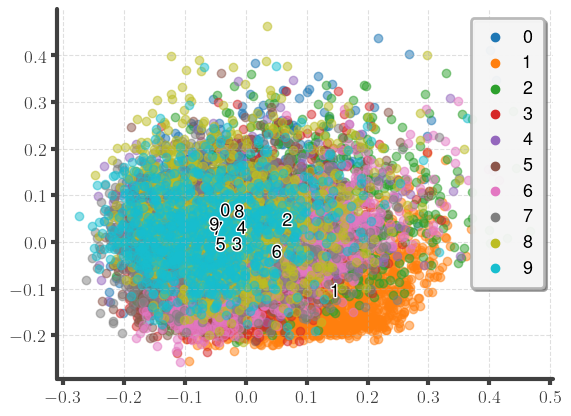

In [20]:
import sklearn


h = data_hid.query(f"Epoch == {epochs[-1]}").to_numpy()

pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(h)
h_red = pca.transform(h)

for digit in range(10):
    h_red_digit = h_red[labels == digit]
    plt.scatter(h_red_digit[:, 0], h_red_digit[:, 1], label=f"{digit}")
plt.legend()

ax = plt.gca()
print(ax.collections)

pub_show()

In [21]:
# loss_theory = simulate.loss(t, z, eta_y_mean_opt, dy2, y0_mean)

# fig, ax = plt.subplots(figsize=(4, 3))
# plt.gca().set_prop_cycle(None)
# ax.plot(0, 0)
# ax.plot(0, 0)
# ax.plot(t, loss_theory, label=r"loss (theory)", linestyle="--")
# ax.plot(0, 0)
# ax.plot(t, train_loss, label="loss", zorder=1)
# # ax.legend()
# plt.ylim(0, 1)
# plt.xlabel("Epochs")
# if save:
#     pub_show(save_path=traj_path + "loss/" + settings)
# else:
#     pub_show()

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


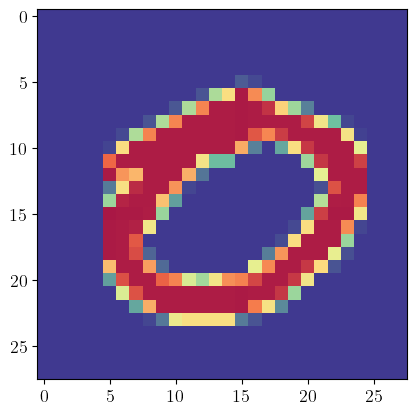

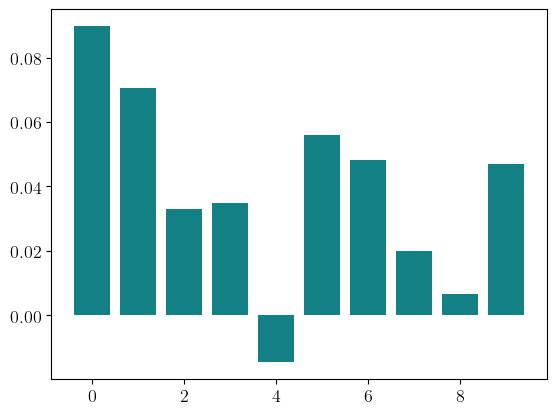

In [22]:
input, output = analyzed_data[0]
print(output)
plt.imshow(input.cpu().reshape(28, 28))
plt.show()
pred = model(input)[0].detach().numpy()
plt.bar(np.arange(10), pred)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

In [23]:
import scipy

N = 10000


X = train_data.train_data[:N]
X = X.reshape(X.shape[0], -1).numpy()
D_x = scipy.spatial.distance.cdist(X, X)

Y = torch.nn.functional.one_hot(train_data.train_labels[:N])
D_y = scipy.spatial.distance.cdist(Y, Y)

A_low = D_x * D_y

pred = np.exp(-A_low) @ A_low @ np.exp(-A_low)
labels = train_data.train_labels[:100]
pred = pred[np.argsort(labels)].T[np.argsort(labels)]

plt.imshow(pred)
plt.show()

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


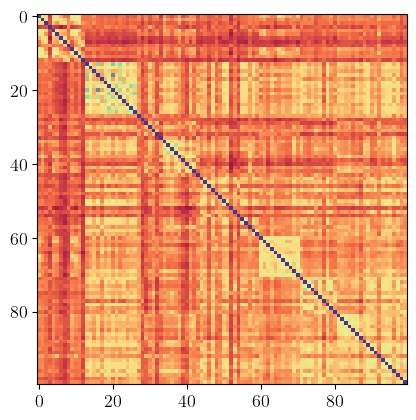

In [ ]:
plt.imshow(D_x[np.argsort(labels)].T[np.argsort(labels)])

In [ ]:
hid_act = get_activations([analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding)

h = hid_act.to_numpy()
# h0 = hid_act_0.to_numpy()
# y0 = out_act_0.to_numpy()

dist2_h = np.array([[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in h] for h_2 in h])
# dist2_h_0 = np.array([[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in h0] for h_2 in h0])
# dist2_y_0 = np.array([[np.linalg.norm(y_1 - y_2) ** 2 for y_1 in y0] for y_2 in y0])
# dist2_x = np.array(
#     [
#         [np.linalg.norm(x_1 - x_2) ** 2 for x_1, y_1 in analyzed_data]
#         for x_2, y_2 in analyzed_data
#     ]
# )
# dist2_y = np.array(
#     [
#         [np.linalg.norm(y_1 - y_2) ** 2 for x_1, y_1 in analyzed_data]
#         for x_2, y_2 in analyzed_data
#     ]
# )

# A_low = np.sqrt(dist2_x * dist2_y)
# A_high = dist2_h_0 - dist2_x * dist2_y_0 / dist2_h_0
# np.fill_diagonal(A_high, 0)
# theory = 0.5 * (A_high + np.sqrt(A_high**2 + 4 * A_low**2))

/tmp/ipykernel_22631/1841357662.py:24: RuntimeWarning: invalid value encountered in divide
  A_high = dist2_h_0 - dist2_x * dist2_y_0 / dist2_h_0


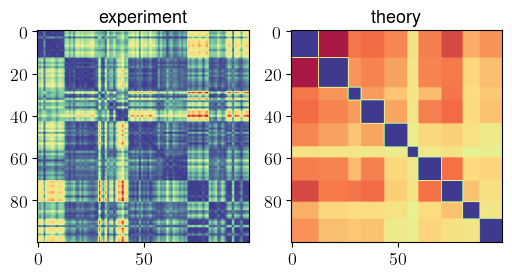

In [ ]:
fig = plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.title(r"experiment")
plt.imshow(dist2_h)

plt.subplot(1, 2, 2)
plt.title(r"theory")
plt.imshow(pred)
plt.show()

In [ ]:
# from IPython.display import clear_output

# H = np.random.random((len(A_low), 50)) * 1e-1
# # H = hid_act_0.to_numpy().copy()

# # rate = 0.1
# rate = 0.01 * lr


# @njit
# def update(H, rate):
#     H_new = H.copy()
#     for i in range(len(H)):
#         for j in range(len(H)):
#             H_new[i] = H_new[i] - (
#                 0.02
#                 * rate
#                 * (H[j] - H[i])
#                 * ((A_low**2)[i, j] - np.linalg.norm(H[i] - H[j]) ** 2)
#             )
#     return H_new


# for n in trange(1000):
#     H_last = H.copy()
#     H = update(H, rate)

#     if n % 50 == 0:
#         clear_output(wait=True)

#         for label in range(10):
#             plt.scatter(H[labels == label, 0], H[labels == label, 1], label=f"{label}")
#         plt.legend(loc="upper left")
#         plt.show()

#         dist2_theory = np.array(
#             [[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in H] for h_2 in H]
#         )
#         plt.imshow(dist2_theory)
#         plt.show()

#     rate = lr / np.linalg.norm(H_last - H)

/tmp/ipykernel_22631/3200084251.py:11: RuntimeWarning: divide by zero encountered in log
  plt.bar(np.arange(10), np.log(n_correct / n_total))


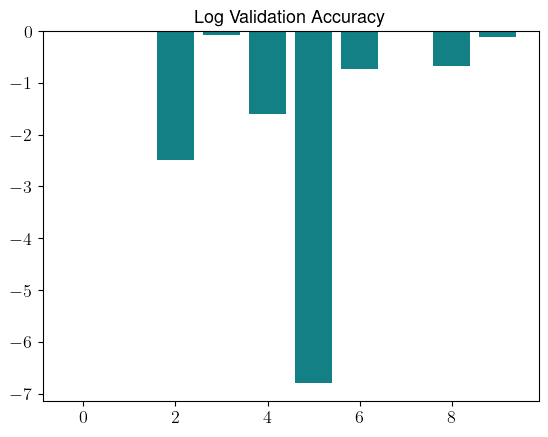

Validation Accuracy: 0.5164


In [ ]:
## Evaluate
n_correct = np.zeros(10)
n_total = np.zeros(10)
for input, output in val_data:
    model_output = model(input)[0].detach().numpy()
    prediction = np.argmax(model_output)
    true = np.argmax(output)
    if prediction == true:
        n_correct[true] += 1
    n_total[true] += 1
plt.bar(np.arange(10), np.log(n_correct / n_total))
plt.title("Log Validation Accuracy")
# plt.savefig(plot_path + f"log_val_acc_gain{gain}.png")
plt.show()
print(f"Validation Accuracy: {np.sum(n_correct)/np.sum(n_total)}")

In [ ]:
labels = np.array([np.argmax(output).item() for input, output in val_data])

for inputs, outputs in DataLoader(val_data, batch_size=len(val_data)):
    act = model(inputs)[1]
act = np.array([layer.detach().numpy() for layer in act])

In [ ]:
@njit
def dist2(act1, act2):
    dist2 = []
    for layer in range(act1.shape[0]):
        if act1 is act2:
            n = len(act1[layer]) * len(act2[layer]) - 1
        else:
            n = len(act1[layer]) * len(act2[layer])
        distance = 0
        for point_1 in act1[layer]:
            for point_2 in act2[layer]:
                distance += np.linalg.norm(point_1 - point_2) / n
        dist2.append(distance)
    return np.array(dist2)

In [ ]:
# baseline = np.array(dist2(act, act))

In [ ]:
# for n in trange(10):
#     plt.plot(
#         dist2(act[:, labels == n], act[:, labels != n]) / baseline,
#         label=f"Distance^2 {n}",
#     )
# plt.legend(loc="lower right")
# plt.savefig(plot_path + f"rel_feature_gain{gain}.png")
# plt.show()

In [ ]:
# for n in trange(10):
#     plt.plot(
#         dist2(act[:, labels == n], act[:, labels != n]),
#         label=f"Distance^2 {n}",
#     )
# plt.legend(loc="lower right")
# plt.savefig(plot_path + f"feature_gain{gain}.png")
# plt.show()